# Predicting Patient Diagnosis from Natural Language Symptoms
## AAI-501 Team 3 Final Project

Team 3 Members:  Tyler Foreman, Christi Moncrief, Tewfik Istanbooly, Mayank Bhatt

Date:  August 14, 2023

GitHub Repository: https://github.com/t4ai/AAI-501-Team3

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import statistics
import spacy
import nltk
import pickle


# SciKit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, make_scorer, f1_score, classification_report
from sklearn import preprocessing
from nltk.corpus import stopwords

import tensorflow_hub as hub
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import keras
from keras.layers import Input, Lambda, Dense
from keras.models import Model
import keras.backend as K

2023-08-07 16:42:45.111790: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Exploratory Data Analysis
 
 - Load data into dataframe
 - Generate and review descriptive statistics of the dataset/variables
 - Plot visualization of data spread for each variable


In [120]:
# Load dataset into dataframe and peek at head
symptoms_disease_df = pd.read_csv('./Symptom2Disease.csv')
symptoms_disease_df.head()

,index,label,text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,4,Psoriasis,"My nails have small dents or pits in them, and..."


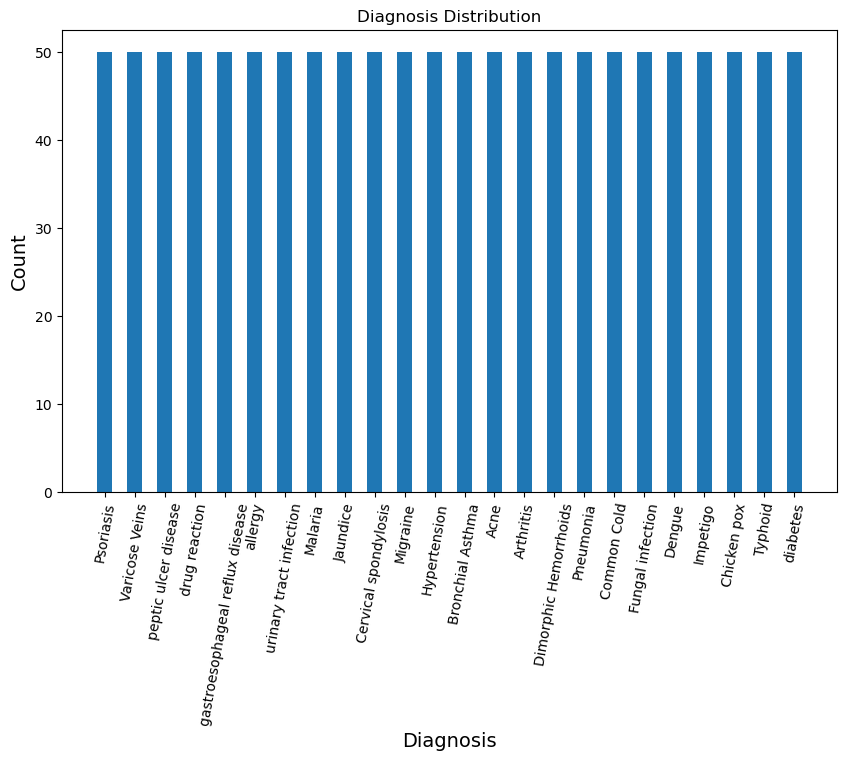

In [121]:
# plot distribution of diagnoses
fig, ax = plt.subplots(figsize=(10, 6))
categories = symptoms_disease_df['label'].value_counts().index
counts = symptoms_disease_df['label'].value_counts().values
plt.bar(categories, counts, width=0.5)

# Add labels
plt.ylabel('Count',fontsize=14)
plt.xlabel('Diagnosis',fontsize=14)
plt.xticks(fontsize=10, rotation = 80)
plt.yticks(fontsize=10)

# Add Title
plt.title('Diagnosis Distribution',fontsize=12);
plt.show()

## Data Cleanup
-  Perform routine cleanup on data:
    - remove punctuation marks
    - convert to lowercase
    - remove numbers
    - remove whitespace
- Remove stop words
- Lemmatize the text
    - Normalize to base words

In [122]:
# helper function to remove special characters/numbers and normalzie to lower case
def string_clean(df, column_name):
    # remove punctuation marks
    punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'
    df[column_name] = df[column_name].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))

    # convert text to lowercase
    df[column_name] = df[column_name].str.lower()

    # remove numbers
    df[column_name] = df[column_name].str.replace("[0-9]", " ", regex=True)

    # remove whitespaces
    df[column_name] = df[column_name].apply(lambda x:' '.join(x.split()))

    return df

# helper function to remove common stop words from the text
def remove_stop_words(df, column_name):
    nltk.download('stopwords', quiet=True) 
    stop = stopwords.words('english')
    df[column_name] = df[column_name].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    return df

# helper function to combine both preprocessing steps above into one function
def preprocess_text(text_arr):
    temp_df = pd.DataFrame({'text': text_arr})
    temp_df = string_clean(temp_df, 'text')
    temp_df = remove_stop_words(temp_df, 'text')
    return temp_df['text'].to_numpy()


In [5]:
# test the preprocessing function
txt = preprocess_text(["WHY heLLo Mr. $Soul I WALKED BY? To Pick UP a %reason!!!!"])
print(txt)

['hello mr. soul walked pick reason']


In [123]:
# run text cleanup on dataset
symptoms_disease_df = string_clean(symptoms_disease_df, 'text')
symptoms_disease_df['text'].head()

0    i have been experiencing a skin rash on my arm...
1    my skin has been peeling, especially on my kne...
2    i have been experiencing joint pain in my fing...
3    there is a silver like dusting on my skin, esp...
4    my nails have small dents or pits in them, and...
Name: text, dtype: object

In [124]:
# remove stop words from dataset
symptoms_disease_df = remove_stop_words(symptoms_disease_df, 'text')
symptoms_disease_df['text'].head()

0    experiencing skin rash arms, legs, torso past ...
1    skin peeling, especially knees, elbows, scalp....
2    experiencing joint pain fingers, wrists, knees...
3    silver like dusting skin, especially lower bac...
4    nails small dents pits them, often feel inflam...
Name: text, dtype: object

##### Lemmatization helper functions

Lemmatization will normalize the text into base dictionary form or root words

In [125]:
# Lemmatize to normalize words - use only for Embeddings below
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# function to lemmatize symptoms text
def lemmatization(symptoms):
    output = []
    for i in symptoms:
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output

## Data Preparation
-  Split data into test/train/validate datasets (80/10/10)
-  Create 3 datasets for experimentation:
    1.  Vectorize natrual language text using TFIDF
    2.  Setup embeddings using ELMo (Embeddings from Language Models)
- Encode labels with one-hot encoding 
- For each of the above, ensure no data leakage by separating train/test


In [126]:
# extract symptom description text to df X (features)
X = symptoms_disease_df['text'].copy()

# extract diagnosis into df for y (labels)
y_raw = symptoms_disease_df['label'].copy()

In [10]:
# Helper functions for one-hot encode/decode for labels (y)
def encode(en, labels):
    enc = en.transform(labels)
    return keras.utils.to_categorical(enc)

def decode(en, one_hot):
    dec = np.argmax(one_hot, axis=1)
    return en.inverse_transform(dec)

# one hot encode y
encoder = preprocessing.LabelEncoder()
encoder.fit(y_raw)


LabelEncoder()

In [127]:
# Split dataset into train, validate, test
X_train, X_test_val, y_train, y_test_val = train_test_split(X, np.asarray(y_raw), test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

In [112]:
# Create one-hot ecoded vectors for y (for NN model)
y_train_enc = encode(encoder, y_train)
y_val_enc = encode(encoder, y_val)
y_test_enc = encode(encoder, y_test)

### Prepare Lemmatized copies of datasets
Lemmatize train, validation and test datsets.  This will be used for experiments with NBC.

In [ ]:
# Copy datasets for lemmatization
X_train_lemm = X_train.copy()
X_val_lemm = X_val.copy()
X_test_lemm = X_test.copy()

# Lemmatize the datasets
X_train_lemm = pd.Series(lemmatization(X_train_lemm))
X_val_lemm = pd.Series(lemmatization(X_val_lemm))
X_test_lemm = pd.Series(lemmatization(X_test_lemm))

### Prepare TF-IDF Vectorized datasets

Vectorize train, validation and test datsets.  First, use CountVectorizer to vectorize the text based on word frequency.  Next, use TF-IDF embedding to create dense vectors based on term frequency and in-document frequency.  The vectorizer and transformer will be trained only on the training dataset to avoid data leakage.

In [145]:
# Start with count vecotrizer to build vocabulary - fit on train data first
count_vectorizer = CountVectorizer()

# Vectorize training data to create bag of words - fit the vectorizor on the training set only to avoid data leakage
X_train_count = count_vectorizer.fit_transform(X_train_lemm)
X_train_count.shape

# Vectorize test and validation data
X_val_count = count_vectorizer.transform(X_val_lemm)
X_test_count = count_vectorizer.transform(X_test_lemm)

# Fit tfidf vectorizer on training count only to avoid data leakage
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_count)

# Vectorize training, val, test data to TFIDF
X_train_tfidf = tf_transformer.transform(X_train_count)
X_val_tfidf = tf_transformer.transform(X_val_count)
X_test_tfidf = tf_transformer.transform(X_test_count)


### Setup ELMo Embeddings Helper Functions

Helper functions for use with ELMo classifier.  These functions intialize the embedder for use in the DNN layer.  Also supporting helper functions to experiement with ELMo separate from DNN.

In [15]:
# Load pre trained ELMo model
elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)

In [16]:

# ELMo Embedding - use as embedding layer in NN
def elmo_embedding(x):
    return elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

def get_elmo_batches(dataset, batch_size):
  return [dataset[i:i+batch_size] for i in range(0,len(dataset),batch_size)]

# save generated embedding to pickle file
def save_embedding(embedding, file_name):
  # save elmo_train_new
  pickle_out = open(file_name,"wb")
  pickle.dump(embedding, pickle_out)
  pickle_out.close()

# load previously generated embedding from pickle file
def load_saved_embedding(file_name):
  pickle_in = open(file_name, "rb")
  return pickle.load(pickle_in)

# use for generating stand alone embeddings (ie: to train shallow classifiers)
def elmo_preprocess_embeddings(x):
  embeddings = elmo(x, signature="default", as_dict=True)["elmo"]

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    # return average of ELMo features
    return sess.run(tf.reduce_mean(embeddings,1))


### Lemmatize copies of the datasets for use with ELMo experiements

These copies will be used as part of experiments to train the ELMo classifer model on different preprocessing techniques

In [111]:
# Copy datasets for elmo
X_train_elmo = X_train.copy()
X_val_elmo = X_val.copy()
X_test_elmo = X_test.copy()

# Lemmatize the datasets
X_train_elmo = pd.Series(lemmatization(X_train_elmo))
X_val_elmo = pd.Series(lemmatization(X_val_elmo))
X_test_elmo = pd.Series(lemmatization(X_test_elmo))

In [18]:
# peek at the lemmatized data
print(X_train.values[2])
print(X_train_elmo.values[2])

standing walking long periods time causing lot pain legs. feels like cramp becomes worse longer feet.
stand walk long period time cause lot pain leg . feel like cramp become worse long foot .


## Model Training and Tuning
-  Run two experiments with different model architectures and data preparation:
    -  Experiment 1: Train a Naive Bayes Classifier usin TF-IDF vectorized features
    -  Experiment 2: Train a neural network classifier with an ELMo text embedding
-  For each experiment:
    -  Train the model on each experimental dataset
    -  Validate against validation dataset
    -  Tune hyperparameters as necessary to optimize performance
    -  Repeat until optimized
    -  Measure model performance

### Experiment 1: Train Naive Bayes Classifer on TF-IDF embedded data

Fit the Naive Bayes MultiNomial classifer using the TF-IDF transformed dataset.

Evaluate accuracy performance and performance across classes.

In [97]:
# Initialize Naive Bayes Classifier
clf1 = MultinomialNB()

# Train classifier
clf1.fit(X_train_tfidf, y_train)

MultinomialNB()

In [98]:
# get accuracy score
score_val = clf1.score(X_val_tfidf, y_val)
print("Accuracy score: {}".format(round(score_val, 4)))

Accuracy score: 0.9167


In [99]:
# run predictions and display classification report to see performance across classes
predictions = clf1.predict(X_val_tfidf)
print(classification_report(y_val, predictions))

                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00         6
                      Arthritis       1.00      1.00      1.00         7
               Bronchial Asthma       1.00      1.00      1.00         5
           Cervical spondylosis       1.00      1.00      1.00         2
                    Chicken pox       1.00      0.83      0.91         6
                    Common Cold       1.00      1.00      1.00         6
                         Dengue       0.67      0.67      0.67         6
          Dimorphic Hemorrhoids       0.80      1.00      0.89         4
               Fungal infection       1.00      1.00      1.00        11
                   Hypertension       1.00      1.00      1.00         2
                       Impetigo       1.00      1.00      1.00         3
                       Jaundice       1.00      1.00      1.00         7
                        Malaria       0.88      1.

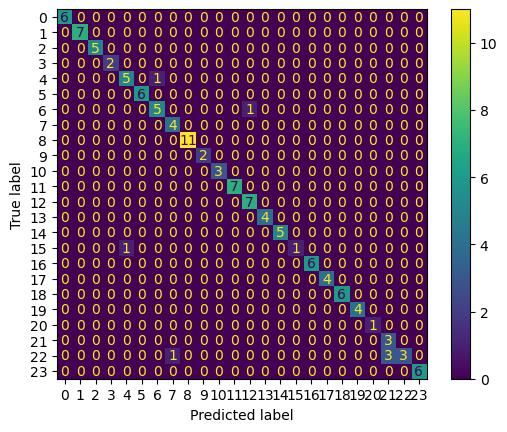

In [24]:
# plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, predictions)).plot();

#### Confusion Matrix Classes:
[0:Acne], [1:Arthritis], [2:Bronchial Asthma], [3:Cervical spondylosis], [4:Chicken pox], [5:Common Cold], [6:Dengue], [7:Dimorphic Hemorrhoids], [8:Fungal infection], [9:Hypertension], [10:Impetigo], [11:Jaundice], [12:Malaria], [13:Migraine], [14:Pneumonia], [15:Psoriasis], [16:Typhoid], [17:Varicose Veins], [18:allergy], [19:diabetes], [20:drug reaction], [21:gastroesophageal reflux disease], [22:peptic ulcer disease]

### Experiment 2: Train Neural Network Classifier with ELMo Embeddings

Build a DNN with the following architecture:

- Input Layer with raw text input
- ELMo embedding layer with 1024 vector output
- Hidden layer with 256 units and ReLu activation
- Output layer with 24 units and Softwmax activation

#### Define Model Architecture and Train
Define a model with a text input layer feeding into ELMo embedding layer, one additional hidden layer and an output layer predicting the 24 classes (diagnoses).  Once trained, weights are saved to a file so training is not necessary every run. 

Note: this step is only necessary for model re-training

In [31]:
# Build Model
def build_nn_model():
    input_text = Input(shape=(1,), dtype=tf.string, name="Text_Input")
    embedding = Lambda(elmo_embedding, output_shape=(1024, ), name="ELMo_Embedding")(input_text)
    dense = Dense(256, activation='relu', name="Dense_Hidden")(embedding)
    pred = Dense(24, activation='softmax', name="Dense_Predict")(dense)
    model = Model(inputs=[input_text], outputs=pred)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [113]:
# Train the model and save to weights file
model = build_nn_model()
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model.fit(X_train_elmo, y_train_enc, epochs=20, batch_size=16)
    model.save_weights('./weights/symptoms-elmo-model-no-proc.h5')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Train on 960 samples
Epoch 1/20
960/960 [==============================] - 199s 207ms/sample - loss: 2.4544 - accuracy: 0.3562
Epoch 2/20
960/960 [==============================] - 199s 208ms/sample - loss: 1.2369 - accuracy: 0.7333
Epoch 3/20
960/960 [==============================] - 173s 180ms/sample - loss: 0.7196 - accuracy: 0.8448
Epoch 4/20
960/960 [==============================] - 175s 182ms/sample - loss: 0.4789 - accuracy: 0.9083
Epoch 5/20
960/960 [==============================] - 161s 168ms/sample - loss: 0.3279 - accuracy: 0.9500
Epoch 6/20
960/960 [==============================] - 159s 166ms/sample - loss: 0.2481 - accuracy: 0.9698
Epoch 7/20
960/960 [==============================] - 172s 179ms/sample - loss: 0.1836 - accuracy: 0.9812
Epoch 8/20
960/960 [==============================] - 186s 194ms/sample - loss: 0.1435 - accuracy: 0.9844
Epoch 9/20
960/960 [==============================] - 181s 188ms/sample - loss: 0.1127 - accuracy: 0.9958
Epoch 10/20
960/960 [====

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


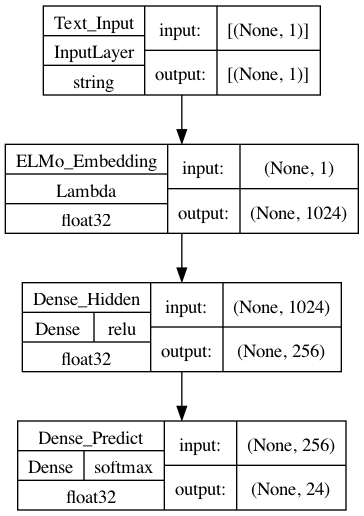

In [32]:
# graphically display model architecture
model1 = build_nn_model()
keras.utils.plot_model(
    model1,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

dict_keys(['loss', 'accuracy'])


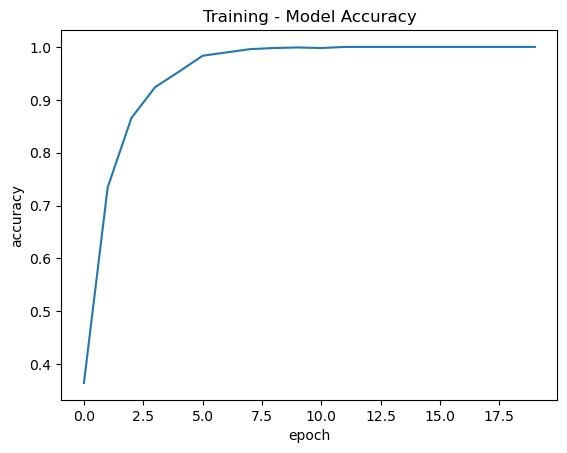

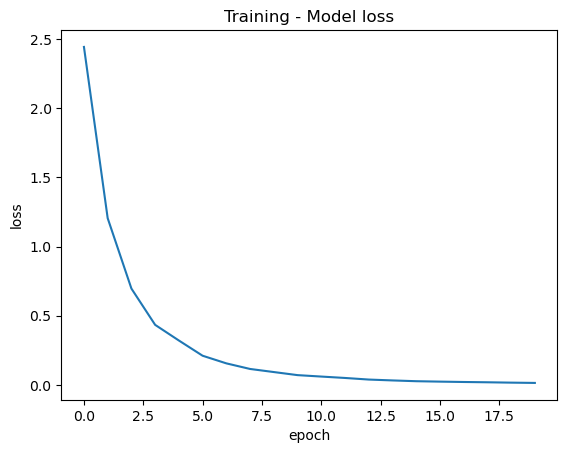

In [61]:
# visualize training progression

print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('Training - Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('Training - Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

#### Helper fuctions for running experiment result analysis

Re-usable functions to run predictions and report on the results for the ELMo classifier

In [115]:
def run_elmo_predictions(X):
    model = build_nn_model()
    with tf.Session() as session:
        K.set_session(session)
        session.run(tf.global_variables_initializer())
        session.run(tf.tables_initializer())
        model.load_weights('./weights/symptoms-elmo-model-no-proc.h5')  
        return model.predict(X, batch_size=16)

def run_elmo_report(y_in, predictions):
    # decode validation labels
    y_in_dec = decode(encoder, y_in)

    # decode predicted labels
    y_preds_dec = decode(encoder, predictions)

    print(classification_report(y_in_dec, y_preds_dec))

def run_confusion_matrix_elmo(y_in, predictions):
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_in, predictions)).plot();

#### Assess model with validation data
With the trained model, run against validation dataset and measure performance.  Note, we have done two training runs - one with non-Lemmatized data and one with Lemmatized data.  The weight files are as follows, load the approrpate one:

- Lemmatized Input Data: symptoms-elmo-model-lemm.h5
- Non-Lemmatized Input Data: symptoms-elmo-model.h5



In [116]:
# Run model on validation dataset
val_predictions = run_elmo_predictions(X_val_elmo)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/Users/tylerforeman/anaconda3/envs/base-ml-39/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [117]:
# Display classification report
run_elmo_report(y_val_enc, val_predictions)

                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00         6
                      Arthritis       1.00      1.00      1.00         7
               Bronchial Asthma       0.83      1.00      0.91         5
           Cervical spondylosis       1.00      1.00      1.00         2
                    Chicken pox       0.80      0.67      0.73         6
                    Common Cold       1.00      1.00      1.00         6
                         Dengue       0.75      0.50      0.60         6
          Dimorphic Hemorrhoids       1.00      1.00      1.00         4
               Fungal infection       1.00      1.00      1.00        11
                   Hypertension       1.00      1.00      1.00         2
                       Impetigo       0.75      1.00      0.86         3
                       Jaundice       1.00      1.00      1.00         7
                        Malaria       1.00      1.

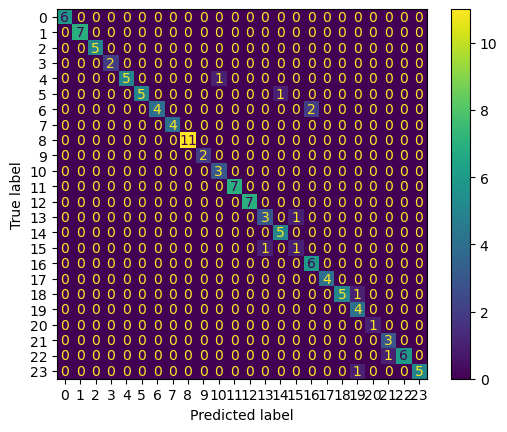

In [31]:
# plot the confusion matrix
run_confusion_matrix_elmo(y_val, decode(encoder, val_predictions))

#### Confusion Matrix Classes:
[0:Acne], [1:Arthritis], [2:Bronchial Asthma], [3:Cervical spondylosis], [4:Chicken pox], [5:Common Cold], [6:Dengue], [7:Dimorphic Hemorrhoids], [8:Fungal infection], [9:Hypertension], [10:Impetigo], [11:Jaundice], [12:Malaria], [13:Migraine], [14:Pneumonia], [15:Psoriasis], [16:Typhoid], [17:Varicose Veins], [18:allergy], [19:diabetes], [20:drug reaction], [21:gastroesophageal reflux disease], [22:peptic ulcer disease]

## Model Comparison and Selection

- Test both models against test dataset
- Compare model performance

#### Assess NBC model with test data
With the trained model, run against test dataset and measure performance.  


In [32]:
# get score
score_test = clf1.score(X_test_tfidf, y_test)
print("[Test] Accuracy score: {}".format(round(score_test, 4)))

[Test] Accuracy score: 0.9667


In [33]:
# run predictions and display report
nbc_test_predictions = clf1.predict(X_test_tfidf)
print(classification_report(y_test, nbc_test_predictions))

                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00         1
                      Arthritis       1.00      1.00      1.00         3
               Bronchial Asthma       1.00      1.00      1.00         6
           Cervical spondylosis       1.00      1.00      1.00         5
                    Chicken pox       1.00      1.00      1.00         6
                    Common Cold       1.00      1.00      1.00         6
                         Dengue       1.00      1.00      1.00         6
          Dimorphic Hemorrhoids       0.75      1.00      0.86         3
               Fungal infection       1.00      1.00      1.00         2
                   Hypertension       1.00      1.00      1.00         8
                       Impetigo       1.00      1.00      1.00         8
                       Jaundice       1.00      1.00      1.00         4
                        Malaria       0.80      1.

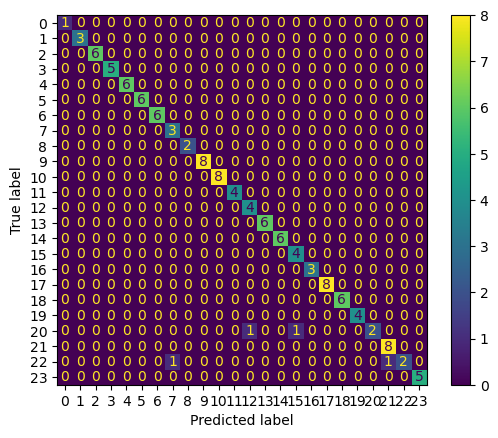

In [34]:
# plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, nbc_test_predictions)).plot();

#### Assess ELMo model with test data
With the trained model, run against test dataset and measure performance.  Note, we have done two training runs - one with non-Lemmatized data and one with Lemmatized data.  The weight files are as follows, load the approrpate one:


In [35]:
# Run model on validation dataset
test_predictions = run_elmo_predictions(X_test_elmo)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/Users/tylerforeman/anaconda3/envs/base-ml-39/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [36]:
# Display classification report
run_elmo_report(y_test_enc, test_predictions)

                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00         1
                      Arthritis       1.00      1.00      1.00         3
               Bronchial Asthma       1.00      1.00      1.00         6
           Cervical spondylosis       1.00      1.00      1.00         5
                    Chicken pox       1.00      0.67      0.80         6
                    Common Cold       0.86      1.00      0.92         6
                         Dengue       0.71      0.83      0.77         6
          Dimorphic Hemorrhoids       1.00      1.00      1.00         3
               Fungal infection       1.00      1.00      1.00         2
                   Hypertension       1.00      0.88      0.93         8
                       Impetigo       1.00      1.00      1.00         8
                       Jaundice       1.00      1.00      1.00         4
                        Malaria       1.00      1.

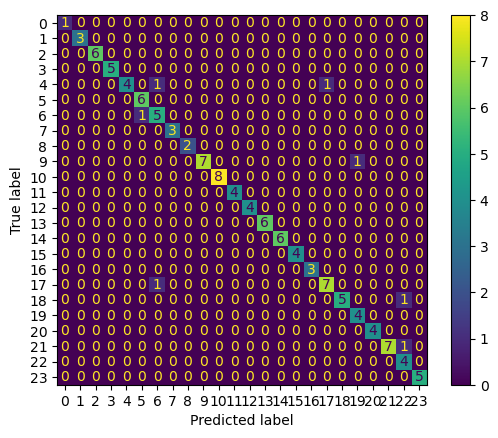

In [37]:
# plot the confusion matrix
run_confusion_matrix_elmo(y_test, decode(encoder, test_predictions))

## Create inference pipeline with NBC

- Data prep pipeline
- Trained model pipeline

In [129]:
# first, create a custom transformer to call the preprocess_text function to do data cleaning steps
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

class TextPreprocessTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = preprocess_text(X)
        return X

In [130]:
# build the pipeline: clean data -> vectorize -> model
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('preprocess', TextPreprocessTransformer()),
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])


In [131]:
# train the pipeline
nbc_model = pipeline.fit(X_train, y_train)

In [132]:
# test performance on test data to ensure it is the same
nbc_pipeline_predictions = nbc_model.predict(X_test)
print(classification_report(y_test, nbc_pipeline_predictions))

                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00         1
                      Arthritis       1.00      1.00      1.00         3
               Bronchial Asthma       1.00      1.00      1.00         6
           Cervical spondylosis       1.00      1.00      1.00         5
                    Chicken pox       1.00      1.00      1.00         6
                    Common Cold       1.00      1.00      1.00         6
                         Dengue       1.00      1.00      1.00         6
          Dimorphic Hemorrhoids       0.75      1.00      0.86         3
               Fungal infection       1.00      1.00      1.00         2
                   Hypertension       1.00      1.00      1.00         8
                       Impetigo       1.00      1.00      1.00         8
                       Jaundice       1.00      1.00      1.00         4
                        Malaria       0.80      1.

#### Run some interactive tests with the NBC pipeline

Test some predictions made by the pipeline with ad-hoc input text

In [133]:
# function to predict diagnosis based on disease text
def run_diagnosis(text):    
    pred_ad_hoc = nbc_model.predict([text])
    print("Based on your sypmtom descriptions, you have {}".format(pred_ad_hoc[0]))


In [135]:
# Run some random symptom descriptions and get diagnosis
run_diagnosis("I have red itchy spots all over my skin.  I have a fever and a headache.")
run_diagnosis("My nose is really stuffy.  I am sneezing alot.  My throat is sore and I am starting to cough.")
run_diagnosis("My legs are sore and bruised.  I can't stand for too long.")


Based on your sypmtom descriptions, you have Chicken pox
Based on your sypmtom descriptions, you have Common Cold
Based on your sypmtom descriptions, you have Varicose Veins


#### Export the model pipeline for use in API

In [140]:
import joblib
joblib.dump(nbc_model, './models/nbc_pipeline.pkl')

['./models/nbc_pipeline.pkl']

## Test NBC accuracy across different mixes to train/test/val

Since class samples were small in each train/test/val split, test overall accuracy with different random mixes and get average accuracy score

In [159]:
# Run with 100 random samples of train/val/test splits
scores = []
for x in range(0, 100):
    
    # Split dataset into train, validate, test
    X_train, X_test, y_train, y_test = train_test_split(X, np.asarray(y_raw), test_size=0.2)

    # train the pipeline
    nbc_model = pipeline.fit(X_train, y_train)

    # test performance on test data to ensure it is the same
    score = pipeline.score(X_test, y_test)
    scores.append(score)



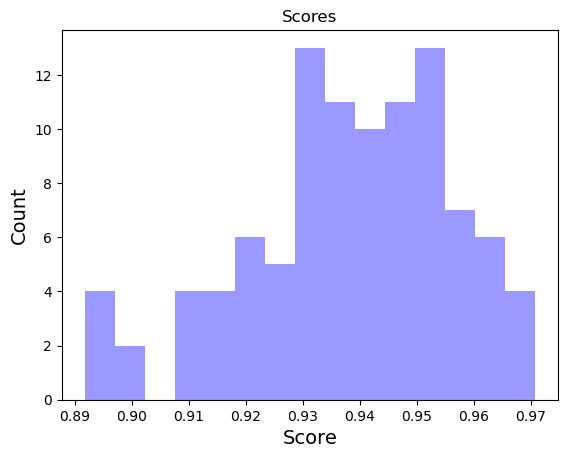

In [160]:
#plot histogram
plt.hist(scores, alpha=0.4, color='blue', bins=15)
plt.ylabel('Count',fontsize=14)
plt.xlabel('Score',fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add Title
plt.title('Scores',fontsize=12);
plt.show()


In [162]:
# get mean accuracy score
print("Mean accuracy score of NBC classifier: {}".format(round(np.mean(scores), 2)))

Mean accuracy score of NBC classifier: 0.94
